<a href="https://colab.research.google.com/github/ChiriKamau/notebooks/blob/main/edge_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Start Karitho

# Edge Detection and Bounding Box Extraction  
### A Step-by-Step Study Based on Gonzalez & Woods (2002)

This notebook presents a structured approach to detecting object edges and drawing a bounding box using classical digital image processing techniques. The methodology and explanations follow the principles described in:

Gonzalez, R. C., & Woods, R. E. (2002). *Digital Image Processing* (2nd ed.). Prentice Hall.

The emphasis is on understanding the theory behind each processing step before considering implementation.


## Objective of the Notebook

The objective of this notebook is to:

- Understand what an edge is in the context of digital images
- Learn why edge detection is based on image derivatives
- Apply edge detection as a foundation for object localization
- Use detected edges to compute a bounding box around an object

The notebook follows the same logical flow used in classical image processing literature, progressing from image acquisition to shape description.


## Digital Image Representation

According to Gonzalez & Woods, a digital image can be modeled as a two-dimensional function:

f(x, y) = i(x, y) · r(x, y)

where:
- i(x, y) represents illumination
- r(x, y) represents reflectance

In most image processing tasks, including edge detection, we are primarily interested in the reflectance component, as it carries information about object structure and boundaries.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

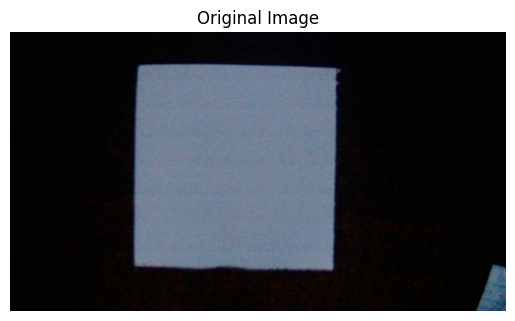

In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Raw GitHub image URL
image_url = "https://raw.githubusercontent.com/ChiriKamau/notebooks/main/capture2.jpg"

# Read image from URL
image_data = cv2.imdecode(
    np.asarray(bytearray(__import__("urllib").request.urlopen(image_url).read()), dtype=np.uint8),
    cv2.IMREAD_COLOR
)

# Convert BGR → RGB for correct display
image_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")

## Conversion to Grayscale

Edge detection relies on detecting abrupt changes in intensity.  
Color images consist of three channels (RGB), but edge operators are defined for scalar-valued functions.

By converting the image to grayscale, we reduce the image to a single intensity function:

f(x, y) ∈ [0, L − 1]

This simplifies analysis and ensures that edge detection is based solely on intensity discontinuities rather than color variations.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

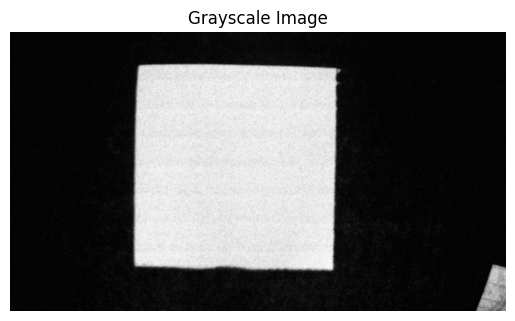

In [5]:
gray = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)

plt.imshow(gray, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")


## Noise Reduction Before Edge Detection

Differentiation amplifies high-frequency components in an image.  
Unfortunately, noise is also a high-frequency component.

Gonzalez & Woods emphasize that smoothing must be applied before edge detection to reduce the effect of noise and prevent false edges.

This notebook uses Gaussian smoothing, which performs weighted averaging and preserves large-scale structures while suppressing small fluctuations.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

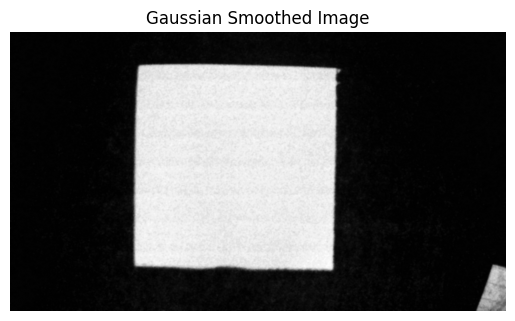

In [6]:
blur = cv2.GaussianBlur(gray, (5, 5), 1.0)

plt.imshow(blur, cmap="gray")
plt.title("Gaussian Smoothed Image")
plt.axis("off")


## Gaussian Smoothing

The Gaussian filter is defined as:

G(x, y) = (1 / 2πσ²) · exp(−(x² + y²) / 2σ²)

Convolving the image with this function produces a smoothed version of the image.  
The parameter σ controls the degree of smoothing: higher values result in stronger noise suppression but reduced edge sharpness.


## Definition of an Edge

An edge is defined as a set of pixels where the image intensity changes abruptly.

Mathematically, edges correspond to points where the first derivative of the image intensity function has a large magnitude.

This makes image gradients the fundamental tool for edge detection.


## First-Order Derivative and the Image Gradient

The gradient of an image f(x, y) is defined as:

∇f = [ ∂f/∂x , ∂f/∂y ]

The gradient magnitude is given by:

|∇f| = √( (∂f/∂x)² + (∂f/∂y)² )

Large gradient magnitudes indicate the presence of edges.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

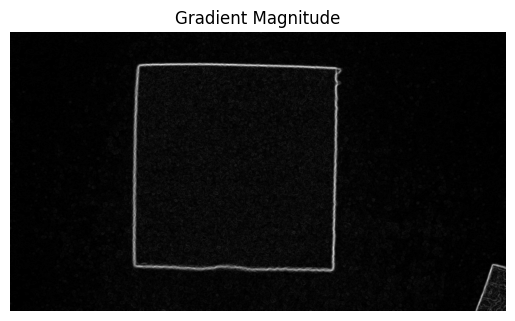

In [7]:
gx = cv2.Sobel(blur, cv2.CV_64F, 1, 0, ksize=3)
gy = cv2.Sobel(blur, cv2.CV_64F, 0, 1, ksize=3)

gradient_magnitude = cv2.magnitude(gx, gy)
gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)

plt.imshow(gradient_magnitude, cmap="gray")
plt.title("Gradient Magnitude")
plt.axis("off")


## Thresholding and Edge Map Formation

After computing the gradient magnitude, we must decide which pixels correspond to true edges.

This is done using thresholding:

g(x, y) = 1  if |∇f(x, y)| ≥ T  
g(x, y) = 0  otherwise

The result is a binary image known as an edge map, which highlights significant intensity transitions.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

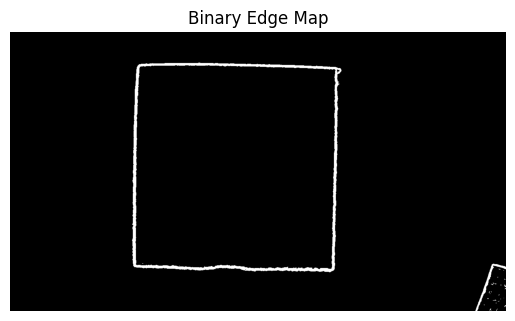

In [8]:
_, edges = cv2.threshold(gradient_magnitude, 50, 255, cv2.THRESH_BINARY)

plt.imshow(edges, cmap="gray")
plt.title("Binary Edge Map")
plt.axis("off")


## Morphological Processing for Edge Linking

Detected edges are often broken or discontinuous due to noise, illumination variation, or threshold selection.

Morphological operations, particularly dilation, are used to:
- Connect nearby edge segments
- Close small gaps
- Improve boundary continuity

This step is essential before extracting object boundaries.


(np.float64(-0.5), np.float64(1279.5), np.float64(719.5), np.float64(-0.5))

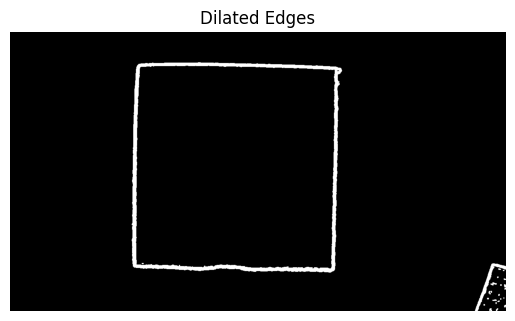

In [9]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
edges_dilated = cv2.dilate(edges, kernel, iterations=1)

plt.imshow(edges_dilated, cmap="gray")
plt.title("Dilated Edges")
plt.axis("off")
